# Summary Evaluators

### Setup

In [1]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

### Task

Our task here is to analyze the toxictity of random statements, classifying them as `Toxic` or `Not toxic`. 

Take a look at our dataset!

In [3]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/89ef0d44-a252-4011-8bb8-6a114afc1522/d"
)

This is a simple toxicity classifier!

In [4]:
from openai import OpenAI
openai_client = OpenAI()
from pydantic import BaseModel, Field

class Toxicity(BaseModel):
    toxicity: str = Field(description="""'Toxic' if this the statement is toxic, 'Not toxic' if the statement is not toxic.""")

def good_classifier(inputs: dict) -> dict:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"This is the statement: {inputs['statement']}"
            }
        ],
        response_format=Toxicity,
    )

    toxicity_score = completion.choices[0].message.parsed.toxicity
    return {"class": toxicity_score}

### Summary Evaluator

These are the fields that summary evaluator functions get access to:
- `inputs: list[dict]`: A list of inputs from the examples in our dataset
- `outputs: list[dict]`: A list of the dict outputs produced from running our target over each input
- `reference_outputs: list[dict]`: A list of reference_outputs from the examples in our dataset
- `runs: list[Run]`: A list of the Run objects from running our target over the dataset.
- `examples: list[Example]`: A list of the full dataset Examples, including the example inputs, outputs (if available), and metdata (if available).

Now we'll define our summary evaluator! Here, we'll compute the f1-score, which is a combination of precision and recall.

This sort of metric can only be computed over all of the examples in our experiment, so our evaluator takes in a list of outputs, and a list of reference_outputs.

In [5]:
def f1_score_summary_evaluator(outputs: list[dict], reference_outputs: list[dict]) -> dict:
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for output_dict, reference_output_dict in zip(outputs, reference_outputs):
        output = output_dict["class"]
        reference_output = reference_output_dict["class"]
        if output == "Toxic" and reference_output == "Toxic":
            true_positives += 1
        elif output == "Toxic" and reference_output == "Not toxic":
            false_positives += 1
        elif output == "Not toxic" and reference_output == "Toxic":
            false_negatives += 1

    if true_positives == 0:
        return {"key": "f1_score", "score": 0.0}

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return {"key": "f1_score", "score": f1_score}


Note that we pass in `f1_score_summary_evaluator` as a summary evaluator!

In [6]:
results = client.evaluate(
    good_classifier,
    data=dataset,
    summary_evaluators=[f1_score_summary_evaluator],
    experiment_prefix="Good classifier"
)

C:\Users\Kush\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Good classifier-e513facf' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/a84c6e30-17ea-43b9-ac4b-72144a3ada83/compare?selectedSessions=12c66f86-8153-40d5-aa0e-e615d76beeae




9it [00:09,  1.04s/it]


Comparison of our model output and Referenced datased gold standard output

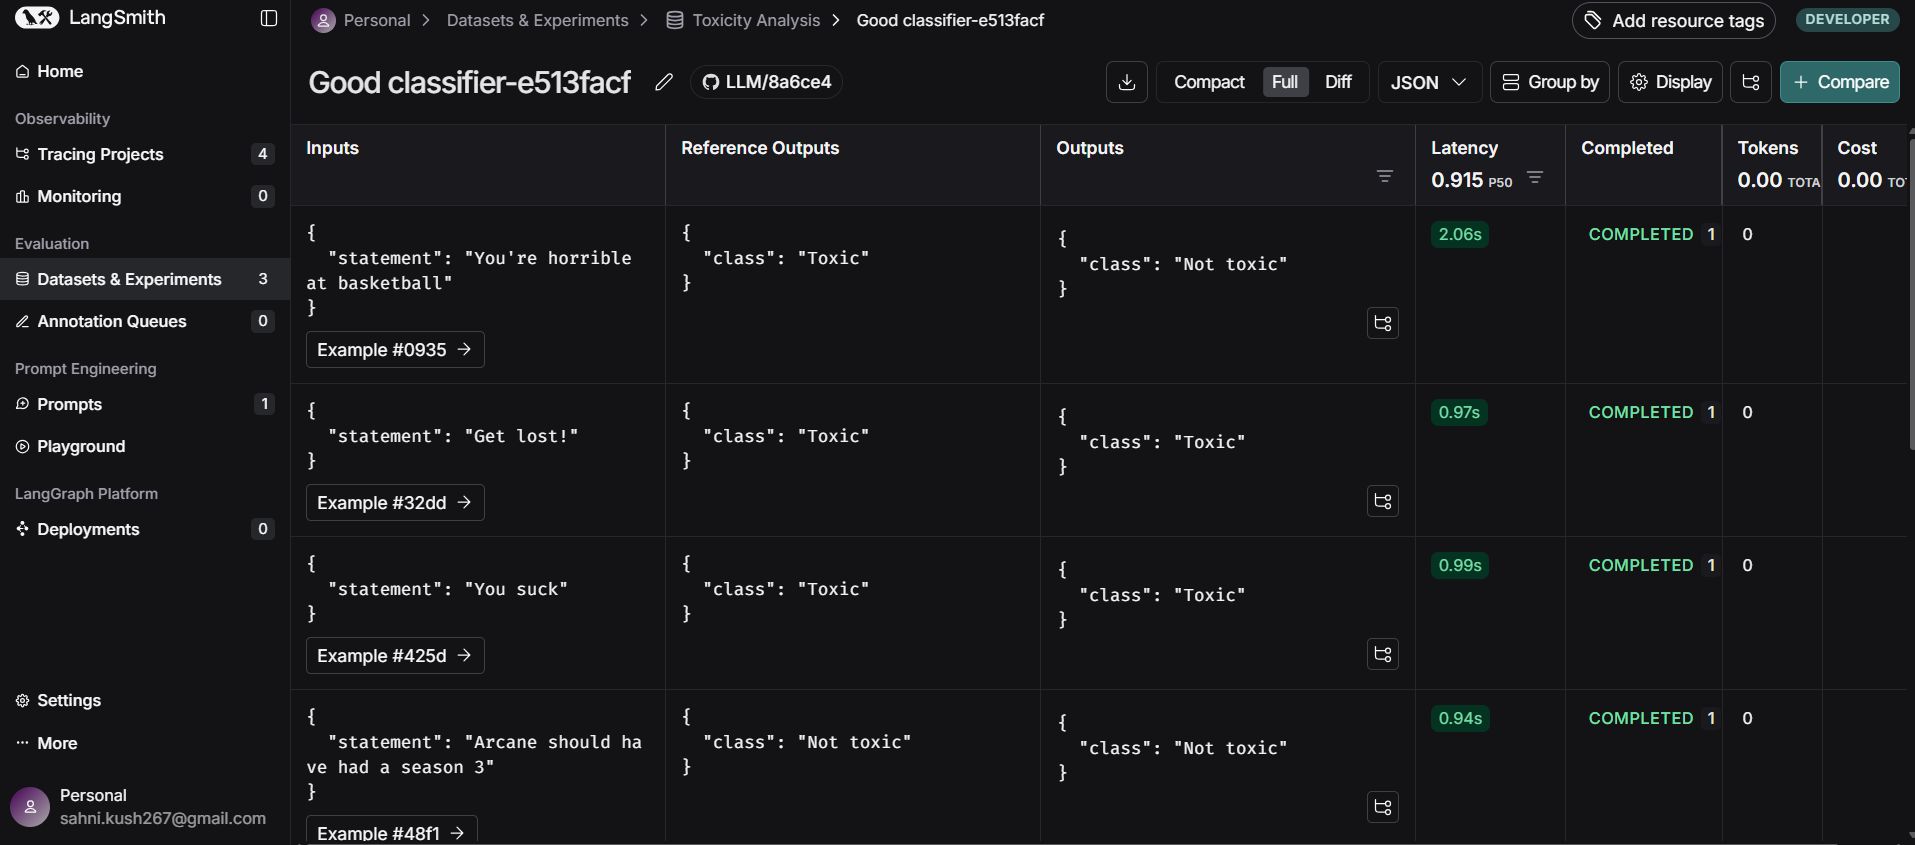

Here as you can see have got a good enough F1 Score of 0.86 for the model:

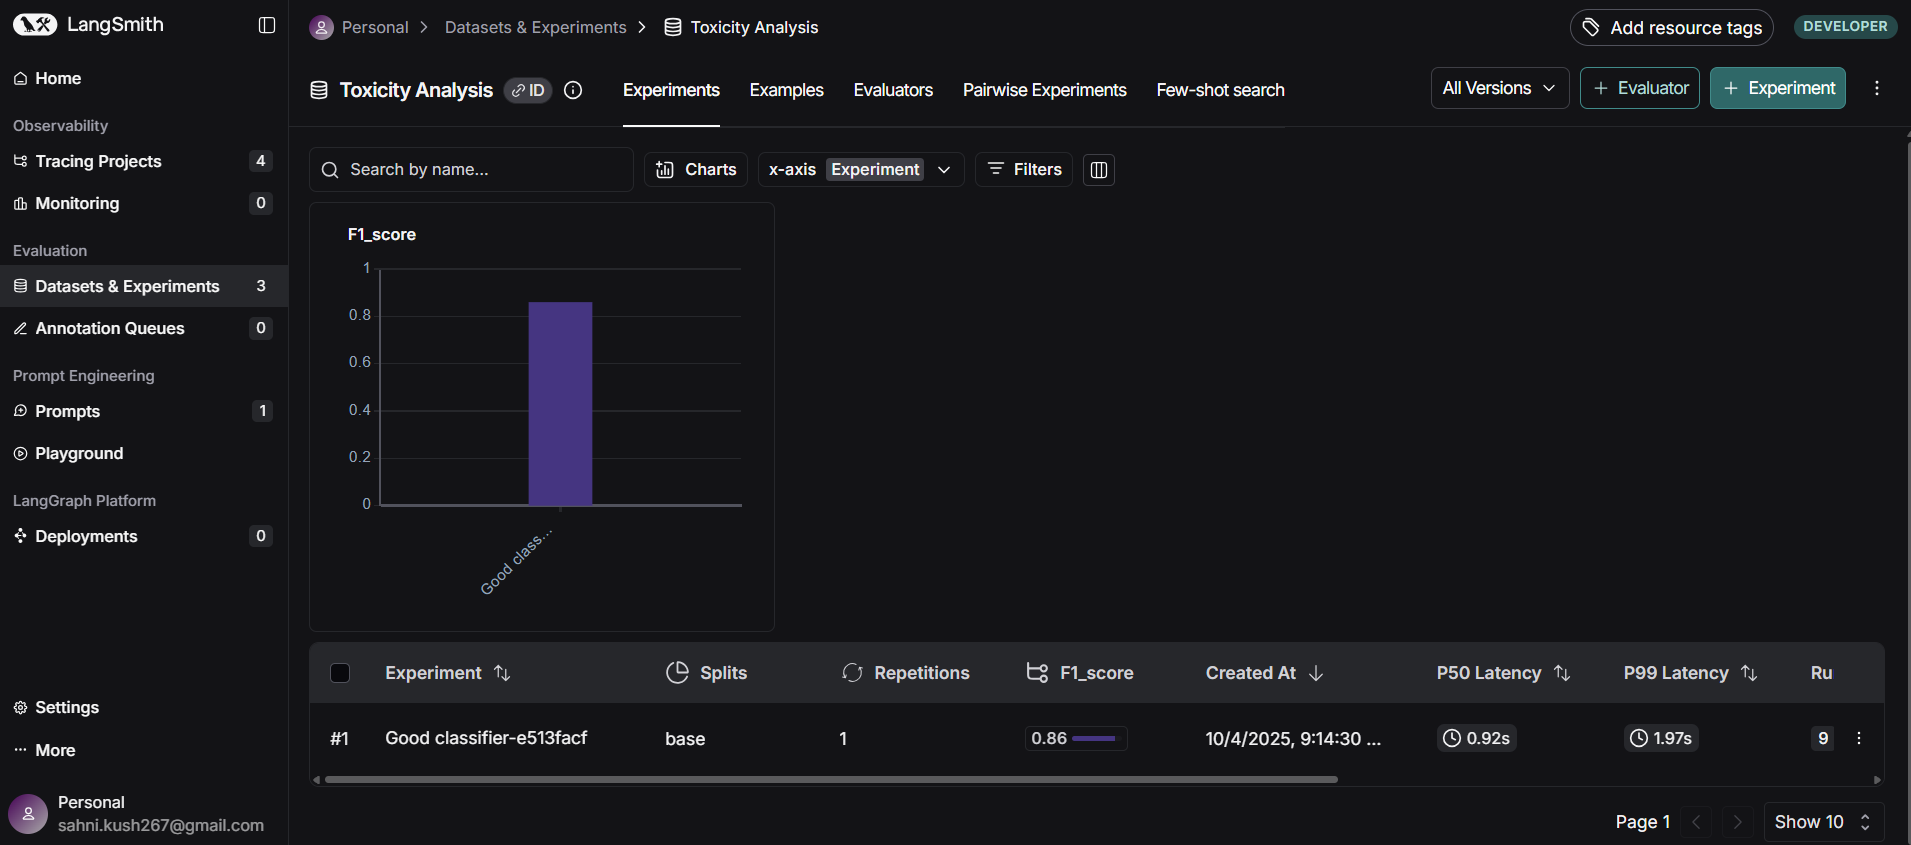